<a href="https://colab.research.google.com/github/EAkeweje/GEOMETRIC-LEARNING-FOR-FLOWS-IN-POROUS-SYSTEMS/blob/main/Updated_Least_Squares_on_porous_media_(from_graph_nodes).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
#Ignore this cell. 
#for access to data files
%cd /content/drive/MyDrive/Skoltech/Research/GDL

/content/drive/MyDrive/Skoltech/Research/GDL


In [26]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import torch
from torch.autograd import Variable
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import PIL
import pandas as pd
from tqdm.notebook import tqdm
import json
import time
import cv2
import random
import glob
import copy

In [27]:
#####custom functions########
import sys
import os
sys.path.append(os.getcwd()+'/scripts')

import utils

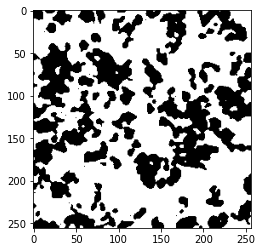

In [28]:
##visualization of pore system
'''
Change directory to any pore image. The function, gen_pore_array, converts the pore image to pore array.
If you choose to use a pore array then use
pore_array = 'path_to_pore array'
'''
pore_array = utils.gen_pore_array("./Dataset/Fluid Flow Simulation/1.png")
plt.imshow(pore_array,'binary')

In [29]:
## Custom fluid flow data object
class FluidDatasetPlus(Dataset):
    """
    Fluid in porous media dataset.
    This pytorch dataset object is an extension of FluidDataset.
    While the earlier version only supports randomly chosen sensor (gauge) positions, 
    this version allows for specification of gauge positions. This is more applicable where the objective is to optimize the sensor (gauge) placement.
    """

    def __init__(self, img_path, root_dir, ks, num_gauge = 0, gauge_pos = None, rnd_seed = 42):
        """
        Args:
            img_path (string): Path to the porous structure image.
            root_dir (string): Directory with all the velocity data.
            ks (int): coarse graining grid size. If no coarse graining is required, set ks to 1
            num_gauge (int): number of sensors
            gauge_pos (list): list of sensor position turples (x,y)
        """
        self.img_path = img_path
        self.ks = ks
        self.root_dir = root_dir
        self.num_gauge = num_gauge

        ##get pore image array
        an_image = PIL.Image.open(self.img_path)
        image_sequence = an_image.getdata()
        image_array = np.array(image_sequence)/255
        k = np.asarray(an_image)[:,:,0]/255
        #adjustment so that the pore spaces are mapped to 0 and the solid immovable parts mapped to 1
        self.pore_array = np.ones_like(k) - k
        #get list velocity data
        self.vel_data = sorted(glob.glob(self.root_dir+'/*.dat'))
        ##coarse grain the system
        self.CG_array = utils.coarse_grain(np.rot90(self.pore_array), self.ks)
        #'install' sensors at pore walls... get the wall boundaries
        #To condition same condition as that used for the graphing image
        CG_array = np.where(self.CG_array <= self.ks**2/2, 0, 1)
        #get total space from working array
        self.total_space = utils.get_total_space(CG_array)
        #if gauge positions not given, pick gauge positions randomly from pore walls
        if not gauge_pos:
          assert self.num_gauge != 0, "Since gauge_pos = None, ensure to specify the number of gauges the program should use. Set gauge > 0"
          boundary_points = utils.get_bounds(1-CG_array)
          #random select gauge spots
          random.seed(rnd_seed)
          self.gauge_space = random.sample(boundary_points, self.num_gauge)
        else:
          #check if no sensor is placed on pore solid
          check = [_ in self.total_space for _ in gauge_pos]
          assert all(check), f"Adjust gauge_pos. The sensor positions in the following indices are not positioned in a pore space: {[i for i, x in enumerate(check) if x == False]}"
          self.gauge_space = gauge_pos
          self.num_gauge = len(gauge_pos)
        # assert self.num_gauge == self.gauge_space, 'Number of guages generated is not equal to the number specified'
        #identify the no remaining no gauge spots (to estimate)
        self.no_gauge_space = copy.deepcopy(self.total_space)
        dup_sensor = list()
        for b_ in self.gauge_space:
          try:
            self.no_gauge_space.remove(b_)
          except:
            dup_sensor.append(b_)
        for b_ in dup_sensor:
          self.gauge_space.remove(b_)

    def __len__(self):
        return len(self.vel_data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        #get velocity field data
        f = np.loadtxt(self.vel_data[idx])
        f = np.reshape(f,(256,256,2))
        f = np.rot90(f)
        #coarse graining velocity data
        CG_f_0 = utils.coarse_grain(f[:,:,0],self.ks)/(self.ks*self.ks)
        CG_f_1 = utils.coarse_grain(f[:,:,1],self.ks)/(self.ks*self.ks)
        #partitions velocity data
        vel_x_ngs = [CG_f_0[i] for i in self.no_gauge_space] #velocity (x-dimension) at no sensor
        vel_y_ngs = [CG_f_1[i] for i in self.no_gauge_space] #velocity (y-dimension) at no sensor
        vel_x_gs = [CG_f_0[i] for i in self.gauge_space] #velocity (x-dimension) from sensor
        vel_y_gs = [CG_f_1[i] for i in self.gauge_space] #velocity (y-dimension) from sensor
        
        return torch.tensor([vel_x_gs,vel_y_gs]), torch.tensor([vel_x_ngs,vel_y_ngs]) #returns sensor data (tensor), no sensor data (tensor)

In [30]:
##LS solver
class LSReconstrutor():
  def __init__(self, dataset, data_split = 0.3, shuffle = True, seed = 42):

    self.data_split = data_split
    self.shuffle = True
    self.data = dataset
    self.seed = seed

    dataset_size = len(self.data)
    indices = list(range(dataset_size))
    split = int(np.floor(self.data_split * dataset_size))
    if self.shuffle :
        np.random.seed(seed)
        np.random.shuffle(indices)
    train_indices, val_indices = indices[split:], indices[:split]

    # Creating PT data samplers and loaders:
    train_sampler = SubsetRandomSampler(train_indices, torch.random.manual_seed(seed))
    valid_sampler = SubsetRandomSampler(val_indices, torch.random.manual_seed(seed))
    #Creating dataloaders
    self.train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
    self.validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler)

  def fit(self):
    #(training) data loading
    for i, (x,y) in enumerate(self.train_loader):
      if i == 0:
        output_stack = y
        input_stack = x
      else:
        output_stack = torch.cat([output_stack,y])
        input_stack = torch.cat([input_stack,x])

    #vectorization of data
    output_dim = output_stack.shape[0]
    input_dim = input_stack.shape[0]
    output = output_stack.view(output_dim,-1).T
    input = input_stack.view(input_dim,-1).T

    #compute coefficient matrices
    self.coef_mat = output @ torch.linalg.pinv(input)
    
    return self.coef_mat

  def predict(self, error_type = None):
    #Inference on validation data
    '''
    pred = A @ X; 
    where A = reconstruction operator, X = sensor measurement
    Also Computes the error; limited to NME, R2 and NFE.
    '''
    for i, (x,y) in enumerate(self.validation_loader):
      x_dim = x.shape[0]
      y_dim = y.shape[0]
      #vectorize validation each snapshot
      x = x.view(x_dim,-1).T
      y = y.view(y_dim,-1).T
      if i == 0:
        target_stack = y.T
        pred_stack = (self.coef_mat @ x).T
      else:
        target_stack = torch.cat([target_stack,y.T])
        pred_stack = torch.cat([pred_stack, (self.coef_mat @ x).T])

    self.target = target_stack
    self.pred = pred_stack

    #losses
    self.NME = self.NME_loss()
    self.NFE = self.NFE_loss()
    self.r2 = self.r2_loss()

    return self.target, self.pred #returns groundtruth and prediction

  #scorings
  def NME_loss(self):
    error = torch.linalg.norm(self.target - self.pred)/torch.linalg.norm(self.target)
    return error
    
  def r2_loss(self):
    target_mean = torch.mean(self.target)
    ss_tot = torch.sum((self.target - target_mean) ** 2)
    ss_res = torch.sum((self.target - self.pred) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2

  def NFE_loss(self):
    target = self.target - self.target.mean(dim =0)
    pred = self.pred - self.target.mean(dim =0)
    error = torch.linalg.norm(target - pred)/torch.linalg.norm(target)
    return error

In [31]:
#Helper function to get node positions
def get_node_pos(G, node_list):
  '''
  inputs:::
  G: nx Graph
  node_list (list): A list of nodes to place gauges

  return:::
  A list of node position in the porous structure
  '''
  pos = []
  for i in node_list:
    pos.append(G.nodes(data = 'node_pos')[i])
  return pos

In [32]:
#get sensor graph
ks = 2 #coarse_graining grid size
G = nx.read_gpickle(f"pore_network_0{ks}.gpickle")

#select nodes
nodes = random.sample(list(np.arange(284)), 100)

#extract sensor (nodes) positions
gauge_pos = get_node_pos(G, nodes)

In [33]:
batch_size = 32
dataset = FluidDatasetPlus(img_path="./Dataset/Fluid Flow Simulation/1.png",
                       root_dir = "./Dataset/Fluid Flow Simulation",
                       ks = ks, gauge_pos = gauge_pos)
print(f'Selected {dataset.num_gauge} nodes')

Selected 100 nodes


In [35]:
LS = LSReconstrutor(dataset)
LS.fit()
LS.predict()
print(LS.NME)

tensor(0.0211)
